## Step 1 :  Time Series Preparation (EDA + Data Engineering)

In [1]:
# Importing Deps
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("../Dataset/ds.csv") # load the dataset

#### Understanding the Dataset


In [3]:
df.head()

,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml)
0,1/1/2023 19:35,Smith's Bar,Rum,Captain Morgan,2555.04,1824.84,0.0,4379.88
1,1/1/2023 10:07,Smith's Bar,Wine,Yellow Tail,1344.37,0.00,0.0,1344.37
2,1/1/2023 11:26,Johnson's Bar,Vodka,Grey Goose,1034.28,0.00,0.0,1034.28
3,1/1/2023 13:53,Johnson's Bar,Beer,Coors,2194.53,0.00,0.0,2194.53
4,1/1/2023 22:28,Johnson's Bar,Wine,Yellow Tail,1020.90,0.00,0.0,1020.90


In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6575 entries, 0 to 6574
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time Served      6575 non-null   str    
 1   Bar Name              6575 non-null   str    
 2   Alcohol Type          6575 non-null   str    
 3   Brand Name            6575 non-null   str    
 4   Opening Balance (ml)  6575 non-null   float64
 5   Purchase (ml)         6575 non-null   float64
 6   Consumed (ml)         6575 non-null   float64
 7   Closing Balance (ml)  6575 non-null   float64
dtypes: float64(4), str(4)
memory usage: 411.1 KB


#### Converting Date (Str) -> Date/Time format


In [10]:
df_copy = df.copy() # working with copy of the org data
df_copy["Date Time Served"] = pd.to_datetime(df_copy["Date Time Served"], errors="coerce") # conversion
print(df_copy["Date Time Served"].min(), df_copy["Date Time Served"].max()) # print the old and new date
print("Invalid dates:", df_copy["Date Time Served"].isna().sum()) # verify all got converted

2023-01-01 10:07:00 2024-01-01 22:46:00
Invalid dates: 0


#### Unique Bars, Types & Brands we sell

In [ ]:
print("Bars:", df["Bar Name"].nunique())
print("Alcohol Types:", df["Alcohol Type"].nunique())
print("Brands:", df["Brand Name"].nunique())

# 6 unique bars in the dataset
# 5 different alcohol type
# 16 different brands

# so total item location series max combinations will be 6 x 16 = 96 different combinations max

Bars: 6
Alcohol Types: 5
Brands: 16


#### Check if any weird negatives (Edge cases)

In [ ]:
cols = ["Opening Balance (ml)", "Purchase (ml)", "Consumed (ml)", "Closing Balance (ml)"]
(df[cols] < 0).sum()

# these edge cases are imp to verify
# there are no unusual negatives, its clean


Opening Balance (ml)    0
Purchase (ml)           0
Consumed (ml)           0
Closing Balance (ml)    0
dtype: int64

##### Verify stock equation consistency

In [ ]:
# In inventory's Opening + Purchase − Consumed ≈ Closing ( Google result)
# eg : opening - 100 bottle, purchase - 40 bottles, consumed - 110 bottles
# result based on eqn - 100+40-110 ≈ 30
# aaproximation in eqn means : wastage/spillgae, theft, wrong entry, broken bottle, errors

check = df["Opening Balance (ml)"] + df["Purchase (ml)"] - df["Consumed (ml)"] - df["Closing Balance (ml)"]
check.describe()

# summary seemes good and promising, it shows consistency based on the real world inventory
# avg mean is close to 0 (so assuming the data is fine)
# std is 0.47 which is small that's a good sign
# min is -7.7 which means closing balance is about 7.7 ml higher
# max (worst case : 9.25)

# 25%, 50%, 75% = 0 -It means at least 75% of rows are perfectly balanced (error = 0).

# No major inventory accounting issues -> data seems fine
# conclude : Data is consistent

count    6575.000000
mean        0.007925
std         0.469464
min        -7.700000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.250000
dtype: float64

#### Aggregate daily demand (preview)

- Total demand per day per bar per brand

In [ ]:
# this helps to aggregate "Total demand per day per bar per brand"
# this assumes in different timeframes same brand is sold so we need to aggregate to find daily preview

df["date"] = df["Date Time Served"].dt.date

daily = (
    df.groupby(["date", "Bar Name", "Alcohol Type", "Brand Name"], as_index=False)["Consumed (ml)"]
      .sum()
)

daily.head()

,date,Bar Name,Alcohol Type,Brand Name,Consumed (ml)
0,2023-01-01,Anderson's Bar,Beer,Miller,0.0
1,2023-01-01,Anderson's Bar,Rum,Bacardi,0.0
2,2023-01-01,Anderson's Bar,Whiskey,Jim Beam,0.0
3,2023-01-01,Anderson's Bar,Wine,Sutter Home,0.0
4,2023-01-01,Brown's Bar,Rum,Captain Morgan,0.0


#### Fast vs Slow Movers (based on daily demand patterns)

In [ ]:
# Summarizing daily demand behavior for each Bar × Alcohol Type × Brand
summary = (
    daily_full.groupby(["Bar Name", "Alcohol Type", "Brand Name"])["Consumed (ml)"]
              .agg(
                  total_ml="sum",                      # total demand across all days
                  avg_daily_ml="mean",                 # average demand per day
                  days="count",                        # total number of days in dataset
                  zero_days=lambda x: (x == 0).sum()    # how many days had zero demand
              )
              .reset_index()
)

# % of days with zero demand (consistency measure)
summary["zero_day_pct"] = summary["zero_days"] / summary["days"]

# Fast movers = high total demand + low zero-demand days
fast_movers = summary.sort_values(
    ["total_ml", "zero_day_pct"],
    ascending=[False, True]
).head(10)

# Slow movers = low total demand + high zero-demand days
slow_movers = summary.sort_values(
    ["total_ml", "zero_day_pct"],
    ascending=[True, False]
).head(10)

print("Top 10 Fast Movers:")
display(fast_movers)

print("\nTop 10 Slow Movers:")
display(slow_movers)


Top 10 Fast Movers:


,Bar Name,Alcohol Type,Brand Name,total_ml,avg_daily_ml,days,zero_days,zero_day_pct
31,Brown's Bar,Wine,Yellow Tail,29588.63,336.234432,88,7,0.079545
88,Thomas's Bar,Vodka,Grey Goose,28510.30,331.515116,86,7,0.081395
37,Johnson's Bar,Rum,Captain Morgan,28319.66,286.057172,99,13,0.131313
72,Taylor's Bar,Vodka,Grey Goose,28017.89,337.564940,83,5,0.060241
24,Brown's Bar,Vodka,Grey Goose,27873.30,339.918293,82,6,0.073171
55,Smith's Bar,Vodka,Absolut,27181.45,316.063372,86,5,0.058140
5,Anderson's Bar,Rum,Captain Morgan,27066.83,370.778493,73,1,0.013699
13,Anderson's Bar,Wine,Barefoot,26989.63,337.370375,80,2,0.025000
38,Johnson's Bar,Rum,Malibu,26356.51,376.521571,70,3,0.042857
39,Johnson's Bar,Vodka,Absolut,26070.31,317.930610,82,7,0.085366



Top 10 Slow Movers:


,Bar Name,Alcohol Type,Brand Name,total_ml,avg_daily_ml,days,zero_days,zero_day_pct
0,Anderson's Bar,Beer,Budweiser,10062.29,209.631042,48,16,0.333333
66,Taylor's Bar,Beer,Heineken,10108.67,252.716750,40,9,0.225000
7,Anderson's Bar,Vodka,Absolut,13113.91,190.056667,69,24,0.347826
81,Thomas's Bar,Beer,Coors,13196.20,231.512281,57,19,0.333333
82,Thomas's Bar,Beer,Heineken,13302.41,283.030000,47,8,0.170213
6,Anderson's Bar,Rum,Malibu,13594.76,222.864918,61,21,0.344262
48,Smith's Bar,Beer,Budweiser,13615.46,295.988261,46,3,0.065217
94,Thomas's Bar,Wine,Sutter Home,13964.45,221.657937,63,23,0.365079
17,Brown's Bar,Beer,Coors,14029.01,304.978478,46,10,0.217391
67,Taylor's Bar,Beer,Miller,14317.58,242.670847,59,18,0.305085


### 
- In time series forecasting, missing dates and zero demand are not the same.
- If a brand didn’t sell on a day, that day must be recorded as 0 demand, not left missing.
- So we build a full daily grid (all dates × bar × brand) and fill missing demand with 0
- This ensures the model learns the real demand pattern instead of treating gaps as missing data.
- In real-world time series, demand often follows patterns like weekends or specific days. To let forecasting models learn this seasonality, we need a complete daily timeline. So we include every date and fill missing days with zero demand.

In [ ]:
# 1) Full date range
all_dates = pd.date_range(daily["date"].min(), daily["date"].max(), freq="D")
dates_df = pd.DataFrame({"date": all_dates})

# 2) Only real combos (Bar × Alcohol Type × Brand)
real_combos = daily[["Bar Name", "Alcohol Type", "Brand Name"]].drop_duplicates()

# 3) Cross join: (all dates) × (real combos)
dates_df["key"] = 1
real_combos["key"] = 1

full_grid = dates_df.merge(real_combos, on="key").drop("key", axis=1)

# 4) Merge actual demand
daily_full = full_grid.merge(
    daily,
    on=["date", "Bar Name", "Alcohol Type", "Brand Name"],
    how="left"
)

# 5) Fill missing demand with 0
daily_full["Consumed (ml)"] = daily_full["Consumed (ml)"].fillna(0)

# Sanity check
print("daily shape:", daily.shape)
print("daily_full shape:", daily_full.shape)

print("Rows per day unique counts:", daily_full.groupby("date").size().nunique())
# every day has equal number of Bar×Brand×AlcoholType rows -> this should return 1
daily_full.head()

# This forces every day to exist, even if demand is 0:

daily shape: (6575, 5)
daily_full shape: (35136, 5)
Rows per day unique counts: 1


,date,Bar Name,Alcohol Type,Brand Name,Consumed (ml)
0,2023-01-01,Anderson's Bar,Beer,Miller,0.0
1,2023-01-01,Anderson's Bar,Rum,Bacardi,0.0
2,2023-01-01,Anderson's Bar,Whiskey,Jim Beam,0.0
3,2023-01-01,Anderson's Bar,Wine,Sutter Home,0.0
4,2023-01-01,Brown's Bar,Rum,Captain Morgan,0.0


### Completed Step 1 : 

- Business understanding + data preparatrion
- EDA Basic
- basic exploration of Dataset
- Demand definition
- Daily aggregation
- Fast vs slow movers
- Built a complete time series (daily_full) to proceed to step 2

## Step 2 : Forecasting
- How much will we consume in the future?

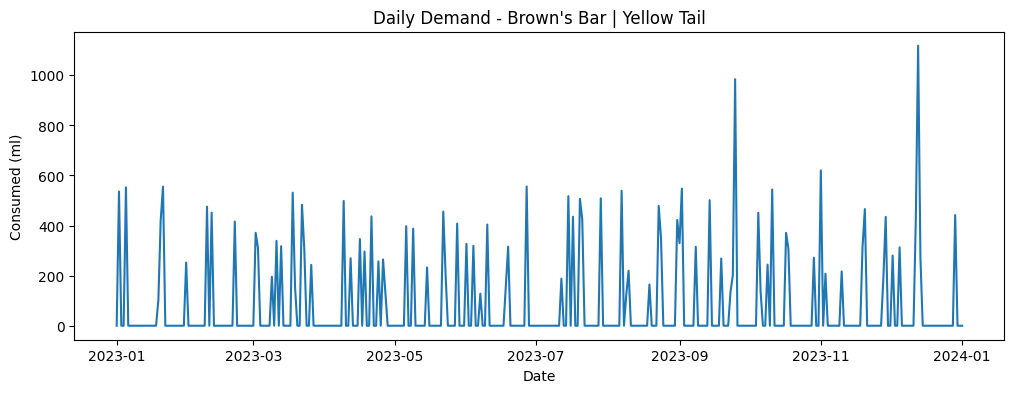

In [ ]:
# a plot can help us understand is the demand smooth or spiky
series = daily_full[
    (daily_full["Bar Name"] == "Brown's Bar") &
    (daily_full["Brand Name"] == "Yellow Tail")
].sort_values("date")

plt.figure(figsize=(12,4))
plt.plot(series["date"], series["Consumed (ml)"])
plt.title("Daily Demand - Brown's Bar | Yellow Tail")
plt.xlabel("Date")
plt.ylabel("Consumed (ml)")
plt.show()


# Plot review :- (insights)
# There are many days at 0
# It's not a smooth “retail demand”. DEMAND is intermittent.
# Some days are ~100–500 ml, and a few days go near 1000+ ml.
# therefore, So safety stock matters.
# No obvious upward/downward trend
# Demand doesn’t steadily increase.
# So simple forecasting baselines will work well. since (no strong long-term rise or fall)

#### Demo check MA7 vs Seasonal Naive on one bar-brand series
- Bar Name: Brown's Bar
- Brand Name: Yellow Tail


In [ ]:

ts = series[["date", "Consumed (ml)"]].copy()
ts = ts.sort_values("date").reset_index(drop=True)
ts.rename(columns={"Consumed (ml)": "y"}, inplace=True)

# Time split (80% train, 20% test)
split = int(len(ts) * 0.8)
train = ts.iloc[:split].copy()
test = ts.iloc[split:].copy()

# Combine to compute rolling predictions safely
ts["pred_ma7"] = ts["y"].shift(1).rolling(7).mean()   # uses last 7 days before today
ts["pred_seasonal_naive"] = ts["y"].shift(7)          # same day last week

# Extract test predictions
test = ts.iloc[split:].copy()

# Fill missing predictions (early days) with 0
test["pred_ma7"] = test["pred_ma7"].fillna(0)
test["pred_seasonal_naive"] = test["pred_seasonal_naive"].fillna(0)

# MAE function
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

mae_ma7 = mae(test["y"], test["pred_ma7"])
mae_seasonal = mae(test["y"], test["pred_seasonal_naive"])



# Now lets compare 2 baseline models to see accuracy 

# Model 1: Rolling 7-day Moving Average (MA7)
# (Forecast = average of last 7 days.)
print("MAE (Rolling 7-day moving average):", round(mae_ma7, 2))

# Model 2: Seasonal Naive (7-day lag)
# (Forecast = value from the same day last week.)
print("MAE (Seasonal naive, 7-day lag):", round(mae_seasonal, 2))



"""
We compared two baselines. The 7-day moving average achieved lower MAE (132) than the weekly
seasonal naive (134.43), suggesting demand is noisy and intermittent rather than strongly
weekly-seasonal. So MA7 is the better baseline.
"""


# On average, MA7 forecast is off by 132 ml per day. -> Model 1 
# On average, this forecast is off by 134.43 ml per day -> Model 2


print("Demo series used:", "Brown's Bar | Yellow Tail")

MAE (Rolling 7-day moving average): 132.25
MAE (Seasonal naive, 7-day lag): 134.43


### Now we run on the whole dataset to check weather based on our Demo, seasonal naive is better than MA7

In [67]:
import numpy as np
import pandas as pd

results = []

group_cols = ["Bar Name", "Alcohol Type", "Brand Name"]

for keys, g in daily_full.groupby(group_cols):
    g = g.sort_values("date").reset_index(drop=True)

    y = g["Consumed (ml)"].values

    # skip very short series (not enough history)
    if len(y) < 30:
        continue

    # time split (80/20)
    split = int(len(y) * 0.8)

    # rolling MA7 forecast (uses previous 7 days)
    pred_ma7 = pd.Series(y).shift(1).rolling(7).mean().values

    # seasonal naive (7-day lag)
    pred_seasonal = pd.Series(y).shift(7).values

    # test portion
    y_test = y[split:]
    ma7_test = np.nan_to_num(pred_ma7[split:], nan=0.0)
    seasonal_test = np.nan_to_num(pred_seasonal[split:], nan=0.0)

    mae_ma7 = np.mean(np.abs(y_test - ma7_test))
    mae_seasonal = np.mean(np.abs(y_test - seasonal_test))

    results.append({
        "Bar Name": keys[0],
        "Alcohol Type": keys[1],
        "Brand Name": keys[2],
        "n_days": len(y),
        "mae_ma7": mae_ma7,
        "mae_seasonal": mae_seasonal,
        "best_model": "MA7" if mae_ma7 < mae_seasonal else "SeasonalNaive"
    })

results_df = pd.DataFrame(results)

results_df.head()

,Bar Name,Alcohol Type,Brand Name,n_days,mae_ma7,mae_seasonal,best_model
0,Anderson's Bar,Beer,Budweiser,366,0.000000,0.000000,SeasonalNaive
1,Anderson's Bar,Beer,Coors,366,78.835444,93.205000,MA7
2,Anderson's Bar,Beer,Heineken,366,71.541351,73.397838,MA7
3,Anderson's Bar,Beer,Miller,366,58.844093,62.562703,MA7
4,Anderson's Bar,Rum,Bacardi,366,92.196371,92.470135,MA7


In [ ]:
# tested count on 96 -> 6 bars × 16 brands, roughly
results_df["best_model"].value_counts()
results_df[["mae_ma7", "mae_seasonal"]].describe()


# MA7 performed better in 69 out of 96 series, so I selected MA7 as the default forecasting method

,mae_ma7,mae_seasonal
count,96.000000,96.000000
mean,92.624361,97.527186
std,31.577648,35.025622
min,0.000000,0.000000
25%,71.705975,71.467027
50%,93.633736,99.047432
75%,114.127640,122.925878
max,154.218205,165.422973


### This proves that based on our Demo, MA7 is better than Seasonal Naive

- just because we had in demo Seasonal better, doesnt mean it has to better when used against whole datset

In [ ]:
# so overall based on the whole dataset it seemes :
# MA7 performs better on average across the dataset.

# So MA7 is the best “default” forecasting method for this dataset.

results_df["best_model"].value_counts()

best_model
MA7              69
SeasonalNaive    27
Name: count, dtype: int64

##### “Across 96 (Bar × Brand) time series (6 bars × 16 brands), MA7 outperformed seasonal naive in 69 cases (~72%).”
##### MA7 also achieved a lower average MAE across all series, indicating that demand is generally noisy/intermittent rather than strongly weekly-seasonal.
##### Therefore, MA7 is selected as the default forecasting method for the inventory recommendation system in our CASE


### Tomarrow's Demand using MA7

In [83]:
group_cols = ["Bar Name", "Alcohol Type", "Brand Name"]

# last date in dataset
last_date = daily_full["date"].max()
tomorrow = last_date + pd.Timedelta(days=1)

# take last 7 days for each series

#  take the last 7 days
#  calculate the mean consumption
#  that mean is the 7-day moving average forecast for tomorrow
last_7 = (
    daily_full[daily_full["date"] > last_date - pd.Timedelta(days=7)]
    .groupby(group_cols)["Consumed (ml)"]
    .mean()
    .reset_index()
)

last_7.rename(columns={"Consumed (ml)": "forecast_tomorrow_ml"}, inplace=True)
last_7["forecast_date"] = tomorrow

last_7.head()

# Anderson’s Bar | Beer | Coors -> 45.86 ml
# based on the last 7 days, tomorrow Coors demand is expected around 46 ml

# Budweiser and Miller show 0 in Andreson's bar
# means: in the last 7 days, they were not consumed → forecast becomes 0


,Bar Name,Alcohol Type,Brand Name,forecast_tomorrow_ml,forecast_date
0,Anderson's Bar,Beer,Budweiser,0.000000,2024-01-02
1,Anderson's Bar,Beer,Coors,45.865714,2024-01-02
2,Anderson's Bar,Beer,Heineken,55.071429,2024-01-02
3,Anderson's Bar,Beer,Miller,0.000000,2024-01-02
4,Anderson's Bar,Rum,Bacardi,256.521429,2024-01-02


## STEP 3 : Inventory Recommendation (Par Level) using (MA7).

- Helps to solve “How much stock should we keep so we don’t run out?”
- The real-world logic you order today.But stock doesn’t arrive instantly.It arrives after lead time.
- Example: You place order today, It arrives in 1-2 days So you must keep enough stock to survive those 1-2 days.
- Lets keep it 2 for reasonability
- Lead time - 2
- Service level 95% (z = 1.65)

In [88]:
# Eg : if the avg demand is 300 ml/day and lead time is 2 days
# then lead time demand is 300 * 2 = 600ml

# therfore, Assuming we need 600 ml just to survive until the new stock arrives.

# safety_stock_ml - Because demand is not stable, we add extra.

In [ ]:
import numpy as np

# Assumptions for inventory planning
L = 2        # Lead time = stock arrives 2 days after ordering (assumption)
z = 1.65     # 95% service level (buffer to reduce stockouts)

group_cols = ["Bar Name", "Alcohol Type", "Brand Name"]

# 1) Calculate historical demand behavior for each Bar × Brand
# - mean_daily: average daily consumption
# - std_daily: how much daily demand fluctuates (volatility)
hist_stats = (
    daily_full.groupby(group_cols)["Consumed (ml)"]
              .agg(std_daily="std", mean_daily="mean")
              .reset_index()
)

# If an item has constant demand, std can become NaN → replace with 0
hist_stats["std_daily"] = hist_stats["std_daily"].fillna(0)

# 2) Combine MA7 forecast (tomorrow demand) with historical volatility
par_table = last_7.merge(hist_stats, on=group_cols, how="left")

# 3) Lead time demand:
# Expected consumption during the lead time period (until stock arrives)
# how much stock we need to survive the next 2 days before replenishment arrives.
par_table["lead_time_demand_ml"] = par_table["forecast_tomorrow_ml"] * L

# 4) Safety stock:
# Extra buffer to handle demand spikes and uncertainty
# Because demand is not stable, we add extra.
par_table["safety_stock_ml"] = z * par_table["std_daily"] * np.sqrt(L)

# 5) Par level (final recommended stock level):
# Par level = demand during lead time + safety stock
par_table["par_level_ml"] = par_table["lead_time_demand_ml"] + par_table["safety_stock_ml"]

# Make output readable
par_table["forecast_tomorrow_ml"] = par_table["forecast_tomorrow_ml"].round(2)
par_table["safety_stock_ml"] = par_table["safety_stock_ml"].round(0)
par_table["par_level_ml"] = par_table["par_level_ml"].round(0)

# Show the highest par-level recommendations (highest stock requirement)
par_table.sort_values("par_level_ml", ascending=False).head(10)


,Bar Name,Alcohol Type,Brand Name,forecast_tomorrow_ml,forecast_date,std_daily,mean_daily,lead_time_demand_ml,safety_stock_ml,par_level_ml
4,Anderson's Bar,Rum,Bacardi,256.52,2024-01-02,159.477717,70.946639,513.042857,372.0,885.0
40,Johnson's Bar,Vodka,Grey Goose,247.11,2024-01-02,160.565822,69.548115,494.214286,375.0,869.0
22,Brown's Bar,Rum,Malibu,226.25,2024-01-02,138.819075,52.068388,452.497143,324.0,776.0
54,Smith's Bar,Rum,Malibu,208.05,2024-01-02,151.800839,67.082459,416.102857,354.0,770.0
73,Taylor's Bar,Vodka,Smirnoff,172.91,2024-01-02,152.444390,63.504481,345.811429,356.0,702.0
88,Thomas's Bar,Vodka,Grey Goose,157.56,2024-01-02,165.036816,77.896995,315.111429,385.0,700.0
56,Smith's Bar,Vodka,Grey Goose,159.89,2024-01-02,161.438115,68.419563,319.788571,377.0,696.0
12,Anderson's Bar,Whiskey,Jim Beam,158.48,2024-01-02,160.729634,70.733716,316.965714,375.0,692.0
70,Taylor's Bar,Rum,Malibu,168.36,2024-01-02,149.199987,60.225929,336.725714,348.0,685.0
76,Taylor's Bar,Whiskey,Jim Beam,137.44,2024-01-02,150.435139,66.581530,274.877143,351.0,626.0


## Step 4 : Simulation

In [122]:

# 1) Pick one demo item

bar = "Brown's Bar"
brand = "Yellow Tail"

item_df = daily_full[
    (daily_full["Bar Name"] == bar) &
    (daily_full["Brand Name"] == brand)
].sort_values("date").reset_index(drop=True)


# 2) Get forecast + variability for this item

row = par_table[
    (par_table["Bar Name"] == bar) &
    (par_table["Brand Name"] == brand)
].iloc[0]

forecast_daily = row["forecast_tomorrow_ml"]   # MA7 forecast (daily)
std_daily = row["std_daily"]                   # historical volatility


# 3) Inventory policy assumptions

L = 2            # lead time (days)
R = 1            # review period (days) -> daily review
z = 1.65         # 95% service level


# Safety stock = (z * std_daily * np.sqrt(L)

# Reorder Point (ROP): stock needed to survive lead time
rop = (forecast_daily * L) + (z * std_daily * np.sqrt(L))

# Par Level (Order-up-to level): stock needed to survive lead time + next review period
par = (forecast_daily * (L + R)) + (z * std_daily * np.sqrt(L))

# Make them clean numbers
rop = float(round(rop, 0))
par = float(round(par, 0))

print(f"Item: {bar} | {brand}")
print(f"Forecast daily demand (MA7): {forecast_daily:.2f} ml")
print(f"Reorder Point (ROP): {rop:.0f} ml")
print(f"Par Level: {par:.0f} ml")


# 4) Optional realism: order in bottles

USE_BOTTLE_ROUNDING = True
BOTTLE_SIZE_ML = 750  # typical bottle size

def round_to_bottle(qty_ml, bottle_size=750):
    """Round up order quantity to nearest bottle multiple."""
    if qty_ml <= 0:
        return 0
    return int(np.ceil(qty_ml / bottle_size) * bottle_size)


# 5) Run simulation

inventory = par  # start at par level (simple starting assumption)
pending_orders = []  # list of dicts: {"arrival_date": ..., "qty": ...}

rows = []

for _, row in item_df.iterrows():
    date = row["date"]
    demand = row["Consumed (ml)"]

    # --- Receive orders arriving today ---
    arrivals_today = [o for o in pending_orders if o["arrival_date"] == date]
    for o in arrivals_today:
        inventory += o["qty"]

    # remove arrived orders
    pending_orders = [o for o in pending_orders if o["arrival_date"] != date]

    # --- Consume demand ---
    fulfilled = min(inventory, demand)
    stockout = demand - fulfilled
    inventory -= fulfilled

    # --- Reorder decision ---
    order_qty = 0

    # Trigger reorder only if inventory is below reorder point
    if inventory <= rop:
        order_qty = par - inventory

        # Optional: bottle rounding
        if USE_BOTTLE_ROUNDING:
            order_qty = round_to_bottle(order_qty, BOTTLE_SIZE_ML)

        arrival_date = date + pd.Timedelta(days=L)
        pending_orders.append({"arrival_date": arrival_date, "qty": order_qty})

    rows.append({
        "date": date,
        "demand_ml": demand,
        "fulfilled_ml": fulfilled,
        "stockout_ml": stockout,
        "ending_inventory_ml": inventory,
        "order_qty_ml": order_qty,
        "pending_orders_count": len(pending_orders)
    })

sim = pd.DataFrame(rows)


# 6) Simulation summary

print("\n--- Simulation Summary ---")
print("Total stockout (ml):", round(sim["stockout_ml"].sum(), 2))
print("Stockout days:", int((sim["stockout_ml"] > 0).sum()))
print("Total orders placed:", int((sim["order_qty_ml"] > 0).sum()))

sim.head()


Item: Brown's Bar | Yellow Tail
Forecast daily demand (MA7): 63.12 ml
Reorder Point (ROP): 527 ml
Par Level: 590 ml

--- Simulation Summary ---
Total stockout (ml): 1287.75
Stockout days: 5
Total orders placed: 39


,date,demand_ml,fulfilled_ml,stockout_ml,ending_inventory_ml,order_qty_ml,pending_orders_count
0,2023-01-01,0.00,0.00,0.0,590.00,0,0
1,2023-01-02,535.95,535.95,0.0,54.05,750,1
2,2023-01-03,0.00,0.00,0.0,54.05,750,2
3,2023-01-04,0.00,0.00,0.0,804.05,0,1
4,2023-01-05,552.50,552.50,0.0,1001.55,0,0


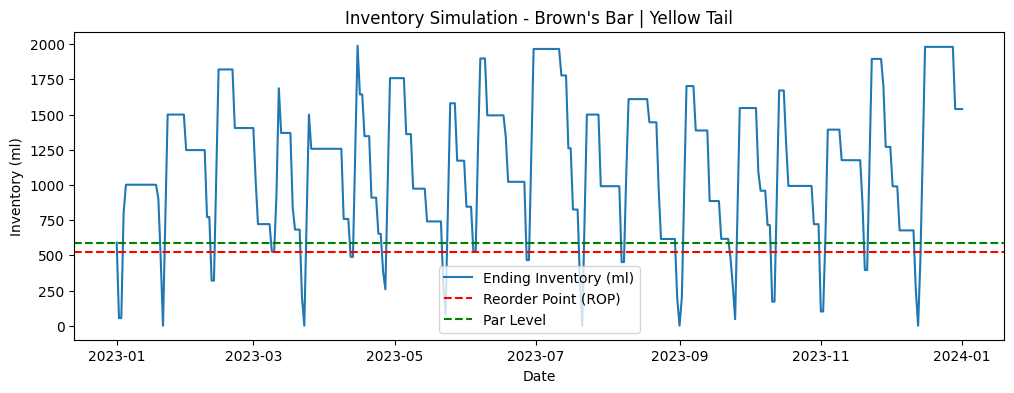

In [123]:
plt.figure(figsize=(12,4))

plt.plot(sim["date"], sim["ending_inventory_ml"], label="Ending Inventory (ml)")

plt.axhline(rop, linestyle="--", color="red", label="Reorder Point (ROP)")
plt.axhline(par, linestyle="--", color="green", label="Par Level")

plt.title(f"Inventory Simulation - {bar} | {brand}")
plt.xlabel("Date")
plt.ylabel("Inventory (ml)")
plt.legend()
plt.show()

- 

### This plot shows how inventory changes over time. Every day, inventory decreases because customers consume the item. When the stock becomes too low, the system orders more. After a few days, the new stock arrives and the inventory goes back up

### This system balances stockouts and overstock using a reorder-point + par-level policy. Bottle-size ordering creates some unavoidable overstock, but it reflects real-world constraints

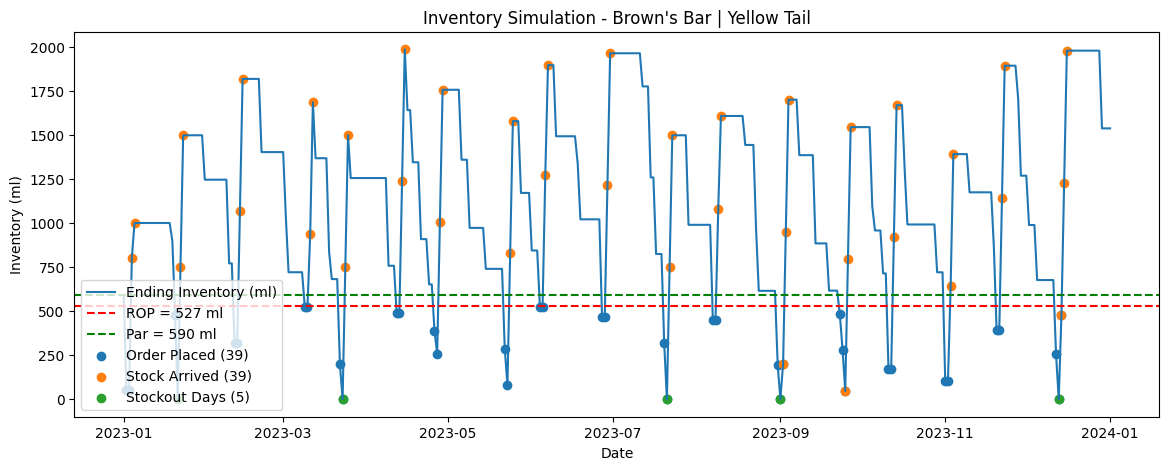

In [124]:
# --- identify key events ---
orders = sim[sim["order_qty_ml"] > 0].copy()
orders["arrival_date"] = orders["date"] + pd.Timedelta(days=L)

# arrival days = where inventory jumps (approx)
arrivals = sim[sim["date"].isin(orders["arrival_date"])].copy()

stockouts = sim[sim["stockout_ml"] > 0].copy()

# --- plot ---
plt.figure(figsize=(14,5))

plt.plot(sim["date"], sim["ending_inventory_ml"], label="Ending Inventory (ml)")

# reorder + par lines
plt.axhline(rop, linestyle="--", color="red", label=f"ROP = {rop:.0f} ml")
plt.axhline(par, linestyle="--", color="green", label=f"Par = {par:.0f} ml")

# order placed markers
plt.scatter(orders["date"], sim.set_index("date").loc[orders["date"], "ending_inventory_ml"],
            label=f"Order Placed ({len(orders)})")

# arrival markers
plt.scatter(arrivals["date"], arrivals["ending_inventory_ml"],
            label=f"Stock Arrived ({len(arrivals)})")

# stockout markers
plt.scatter(stockouts["date"], stockouts["ending_inventory_ml"],
            label=f"Stockout Days ({len(stockouts)})")

plt.title(f"Inventory Simulation - {bar} | {brand}")
plt.xlabel("Date")
plt.ylabel("Inventory (ml)")
plt.legend()
plt.show()


- This blue line is the ending inventory each day. It goes down when the item is consumed
- This red dashed line is the Reorder Point (ROP = 527 ml), Whenever inventory drops below this level, the system places an order
- These blue dots show the days an order was placed
- These orange dots show when stock actually arrived, which causes the inventory to jump up
- This green dashed line is the Par Level (590 ml)
